# Udacity Self Driving Car Advanced Lane Finding

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.



In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

## Compute Camera Calibration Matrix and Distorition Coefficients
The camera picture gets distorted because of the impact of the lens on a camera. We employ CV2 to find the distortion matrix that we can later use to correct an image. The input are images of a chessboard such as the image below.

![chessboard image](camera_cal/calibration1.jpg)

We see that on the side of the iamges there is a distortion. The CV2 function `findChessboardCorners` requires us to tell it how many squares we will use. As we can see in the image above we have a 10 by 7 square chessboard. To let the algorithm find corners in most images we found through trial and error that 9 by 6 leads it to use most images.

In [2]:
import glob
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

def find_corners(filename, idx, num_corners):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, num_corners, None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, num_corners, corners, ret)
        write_name = 'camera_calibrated/corners_found_'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)
        return True
    else:
        print("Could not find corners for image %s with corners %s." % (filename, num_corners))
        return False
    

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    find_corners(fname, idx, (9,6))

Could not find corners for image camera_cal\calibration1.jpg with corners (9, 6).
Could not find corners for image camera_cal\calibration4.jpg with corners (9, 6).
Could not find corners for image camera_cal\calibration5.jpg with corners (9, 6).


We see that we are unable to find corners in three images. Example of how the corners are found are shown below.
![found corners 1](camera_calibrated/corners_found_0.jpg)
![found corners 1](camera_calibrated/corners_found_2.jpg)
![found corners 2](camera_calibrated/corners_found_3.jpg)

## Apply Distortion to Calibrated Images
We now have an camera distortion matrix that we can use to calibrate our camera.

In [3]:
# Test undistortion on an image

# Make a list of calibration images
images = glob.glob('camera_calibrated/corners_found_*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)

    # Get the image size.
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    
    # Undistort the image
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    write_name = 'camera_calibrated/undistorted_'+str(idx)+'.jpg'
    cv2.imwrite(write_name, dst)

We now have the information to correct an image for the camera distortion. An image where this is well visible is the first image,

the original image is,

![original image](camera_cal/calibration1.jpg)

The corrected image is,

![corrected image](camera_calibrated/undistorted_0.jpg)

We clearly see that there is less of a fisheye lens effect on the corrected image.

In [4]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    elif orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_threshold(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

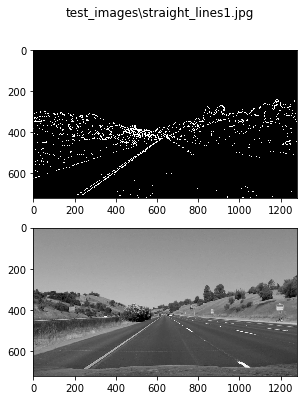

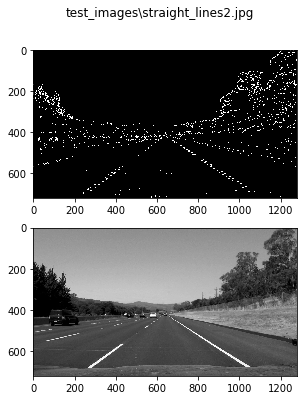

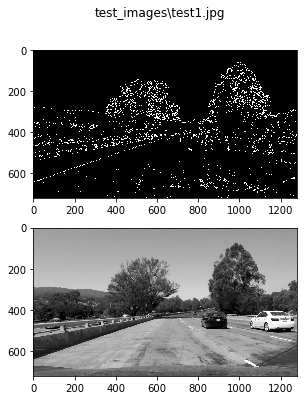

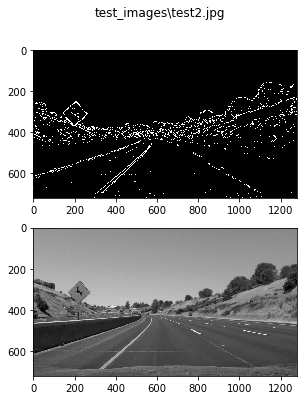

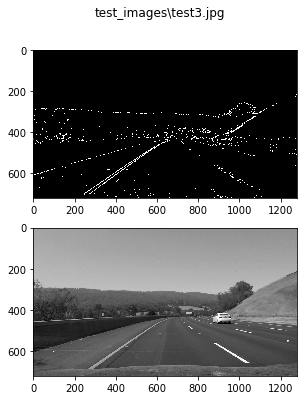

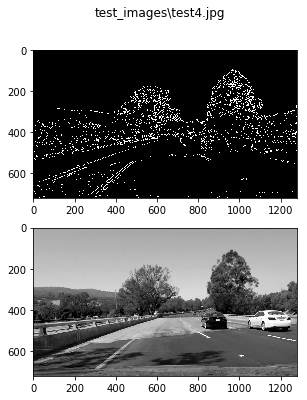

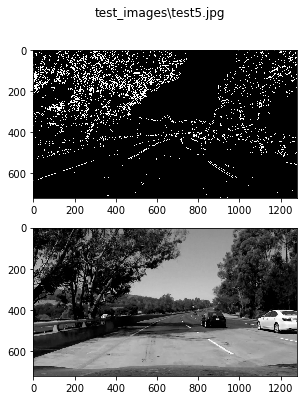

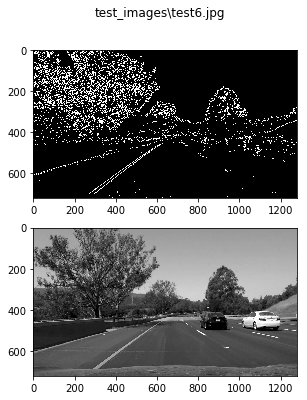

In [6]:
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

images=glob.glob("test_images/*.jpg")

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)    
    # Get the image size.
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None,None)
  
    # Undistort the image
    dst = cv2.undistort(gray, mtx, dist, None, mtx)
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(dst, orient='x', sobel_kernel=ksize, thresh=(15, 100))
    grady = abs_sobel_thresh(dst, orient='y', sobel_kernel=ksize, thresh=(15, 100))
    mag_binary = mag_threshold(dst, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(dst, sobel_kernel=ksize, thresh=(0.7, 1.3))

    combined = np.zeros_like(gray)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    fig = plt.figure(figsize=(6,6))
    fig.suptitle(fname)
    plt.subplot(211)
    plt.imshow(combined, cmap="gray")
    plt.subplot(212)
    plt.imshow(gray, cmap="gray")

## Perspective Correction
To identify the lane curvature we first need to change the perspective of the road. To achieve this we identify four points in a image of the road and map these to coordinates on our output image. We initially started with dots that were very close to the vanishing point, however this resulted in a lot of distortion. The distortion was most likely coming from the interpolation that was required to change two very close points to points with more than 800 pixels apart in the undistorted image. As a result we decided to choose points that were less far away and were only about 125 pixels spaced apart. This left sufficient room to come up with a good interpolation as we will see next.

Below we draw the dots on the original picture. Next we show examples of the perspective corrected view of three scenarios. The first is a curved line, the second a straight line and the third also a straight line.

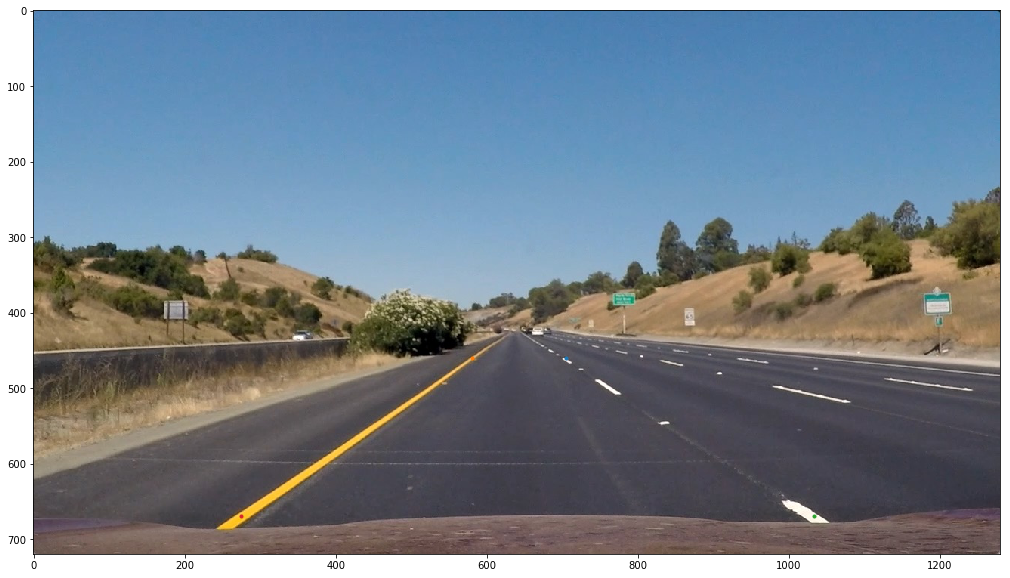

In [5]:
import matplotlib.image as mpimg

img = mpimg.imread('test_images/straight_lines1.jpg')
plt.figure(figsize=(20,10))
plt.imshow(img)
plt.plot(705, 460, '.')
plt.plot(580, 460, '.')
plt.plot(1033, 670, '.')
plt.plot(275, 670, '.')

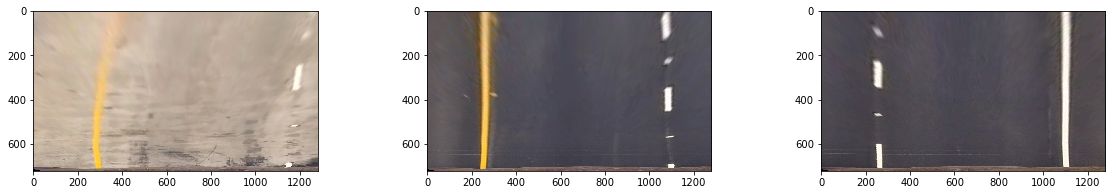

In [6]:
src_pnts = np.float32([[1033,670],          
                  [275,670],
                  [705,460],
                  [580,460]])          

dst_pnts = np.float32([[1100, 700],
                  [250, 700],
                  [1100, 0],
                  [250, 0]])
img_size = (img.shape[1], img.shape[0])
road_camera_M = cv2.getPerspectiveTransform(src_pnts, dst_pnts)
inv_road_camera_M = cv2.getPerspectiveTransform(dst_pnts, src_pnts)
img = mpimg.imread('test_images/test1.jpg')
warped = cv2.warpPerspective(img, road_camera_M, img_size, flags=cv2.INTER_CUBIC)
plt.figure(figsize=(20,10))
plt.subplot(331)
plt.imshow(warped)

img2 = mpimg.imread('test_images/straight_lines1.jpg')
warped = cv2.warpPerspective(img2, road_camera_M, img_size, flags=cv2.INTER_CUBIC)
plt.subplot(332)
plt.imshow(warped)

img3 = mpimg.imread('test_images/straight_lines2.jpg')
warped = cv2.warpPerspective(img3, road_camera_M, img_size, flags=cv2.INTER_CUBIC)
plt.subplot(333)
plt.imshow(warped)


## Threshold Settings
Let us inspect with some harder images what good values would be for the thresholds.

In [7]:
import matplotlib.gridspec as gridspec
import glob

fig = plt.figure(figsize=(18, 18))
gs = gridspec.GridSpec(9, 6)

for i, img_nm in enumerate(glob.iglob('./test_images/vlcsnap*jpg')):
    img = cv2.imread(img_nm, 0)
    ax = plt.subplot(gs[i * 6])
    plt.imshow(img, cmap='gray')
    
    warped = cv2.warpPerspective(img, road_camera_M, img_size, flags=cv2.INTER_LANCZOS4)
    ax = plt.subplot(gs[i * 6 + 1])
    plt.imshow(warped, cmap='gray')
    
    abs_sobel = np.absolute(cv2.Sobel(warped, cv2.CV_64F, 1, 0))
    sobel_x = np.uint8(255*abs_sobel/np.max(abs_sobel))
    ax = plt.subplot(gs[i * 6 + 2])
    plt.imshow(sobel_x, cmap='gray')
    
    abs_sobel = np.absolute(cv2.Sobel(warped, cv2.CV_64F, 0, 1))
    sobel_y = np.uint8(255*abs_sobel/np.max(abs_sobel))
    ax = plt.subplot(gs[i * 6 + 3])
    plt.imshow(sobel_y, cmap='gray')
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(warped, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(warped, cv2.CV_64F, 0, 1, ksize=3)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    ax = plt.subplot(gs[i * 6 + 4])
    plt.imshow(gradmag, cmap='gray')
    
    sobelx = cv2.Sobel(warped, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(warped, cv2.CV_64F, 0, 1, ksize=3)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx)) / np.pi *255
    ax = plt.subplot(gs[i * 6 + 5])
    plt.imshow(absgraddir, cmap='gray')

We see that in certain shade condition the lines can be hard to identify.  Let us perform CLAHE adjustment to see whether we can highlight lines better.

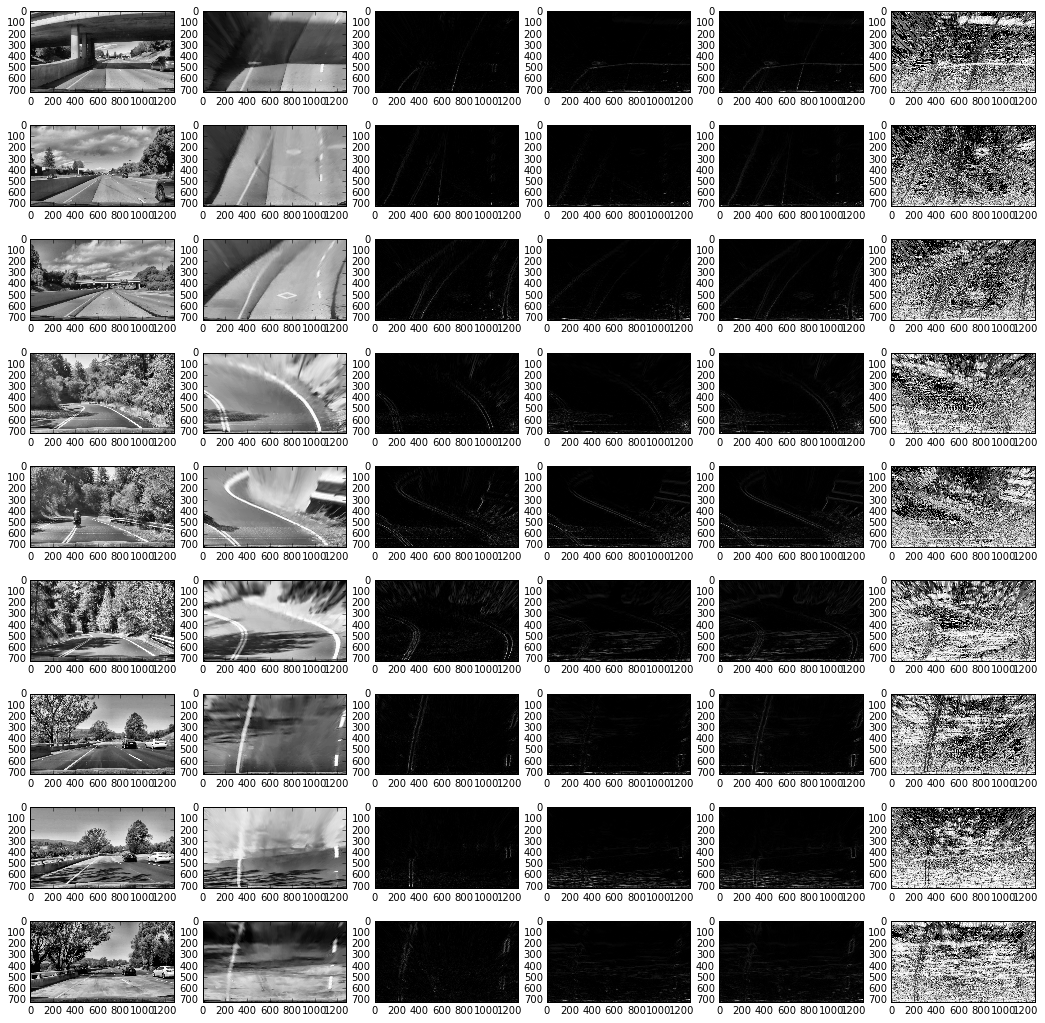

In [54]:
fig = plt.figure(figsize=(18, 18))
gs = gridspec.GridSpec(9, 6)

for i, img_nm in enumerate(glob.iglob('./test_images/vlcsnap*jpg')):
    img = cv2.imread(img_nm,0)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    ax = plt.subplot(gs[i * 6])
    plt.imshow(img, cmap='gray')
    
    warped = cv2.warpPerspective(img, road_camera_M, img_size, flags=cv2.INTER_LANCZOS4)
    ax = plt.subplot(gs[i * 6 + 1])
    plt.imshow(warped, cmap='gray')
    
    abs_sobel = np.absolute(cv2.Sobel(warped, cv2.CV_64F, 1, 0))
    sobel_x = np.uint8(255*abs_sobel/np.max(abs_sobel))
    ax = plt.subplot(gs[i * 6 + 2])
    plt.imshow(sobel_x, cmap='gray')
    
    abs_sobel = np.absolute(cv2.Sobel(warped, cv2.CV_64F, 0, 1))
    sobel_y = np.uint8(255*abs_sobel/np.max(abs_sobel))
    ax = plt.subplot(gs[i * 6 + 3])
    plt.imshow(sobel_y, cmap='gray')
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(warped, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(warped, cv2.CV_64F, 0, 1, ksize=3)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    ax = plt.subplot(gs[i * 6 + 4])
    plt.imshow(gradmag, cmap='gray')
    
    sobelx = cv2.Sobel(warped, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(warped, cv2.CV_64F, 0, 1, ksize=3)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx)) / np.pi *255
    ax = plt.subplot(gs[i * 6 + 5])
    plt.imshow(absgraddir, cmap='gray') 

We see that the y direction for the Sobol operator does not contain much information. Moreover we see that the `arctan` identifies lines as low values, since the lines are black in the image. The gradient magnitude is less useful. Next we will try to increase the kernel size to see whether that can smoothen the results a bit.

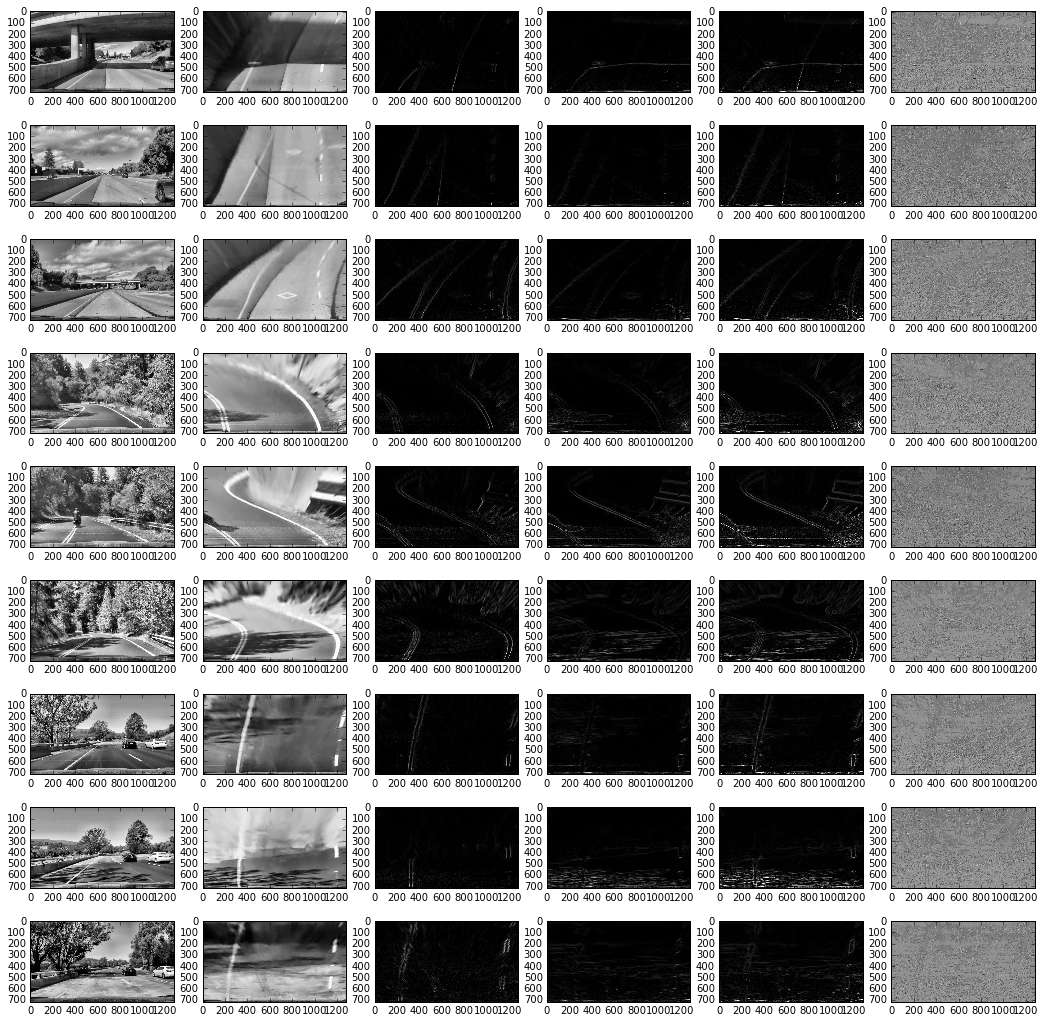

In [57]:
fig = plt.figure(figsize=(18, 18))
gs = gridspec.GridSpec(9, 6)

for i, img_nm in enumerate(glob.iglob('./test_images/vlcsnap*jpg')):
    img = cv2.imread(img_nm,0)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    ax = plt.subplot(gs[i * 6])
    plt.imshow(img, cmap='gray')
    
    warped = cv2.warpPerspective(img, road_camera_M, img_size, flags=cv2.INTER_LANCZOS4)
    ax = plt.subplot(gs[i * 6 + 1])
    plt.imshow(warped, cmap='gray')
    
    abs_sobel = np.absolute(cv2.Sobel(warped, cv2.CV_64F, 1, 0, ksize=5))
    sobel_x = np.uint8(255*abs_sobel/np.max(abs_sobel))
    ax = plt.subplot(gs[i * 6 + 2])
    plt.imshow(sobel_x, cmap='gray')
    
    abs_sobel = np.absolute(cv2.Sobel(warped, cv2.CV_64F, 0, 1, ksize=5))
    sobel_y = np.uint8(255*abs_sobel/np.max(abs_sobel))
    ax = plt.subplot(gs[i * 6 + 3])
    plt.imshow(sobel_y, cmap='gray')
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(warped, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(warped, cv2.CV_64F, 0, 1, ksize=5)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    ax = plt.subplot(gs[i * 6 + 4])
    gradmag = cv2.filter2D(gradmag, -1, kernel) 
    plt.imshow(gradmag, cmap='gray')
    
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx)) / np.pi *255
    ax = plt.subplot(gs[i * 6 + 5])
    kernel = np.array([[-0.5,-0.5,-0.5], [-0.5,5,-0.5], [-0.5,-0.5,-0.5]])
    absgraddir = cv2.filter2D(absgraddir, -1, kernel) 
    plt.imshow(absgraddir, cmap='gray') 

We see increasing the kernel has good results except on the arctan of the outcome of the Sobol operator. Let us use this information to set thresholds.

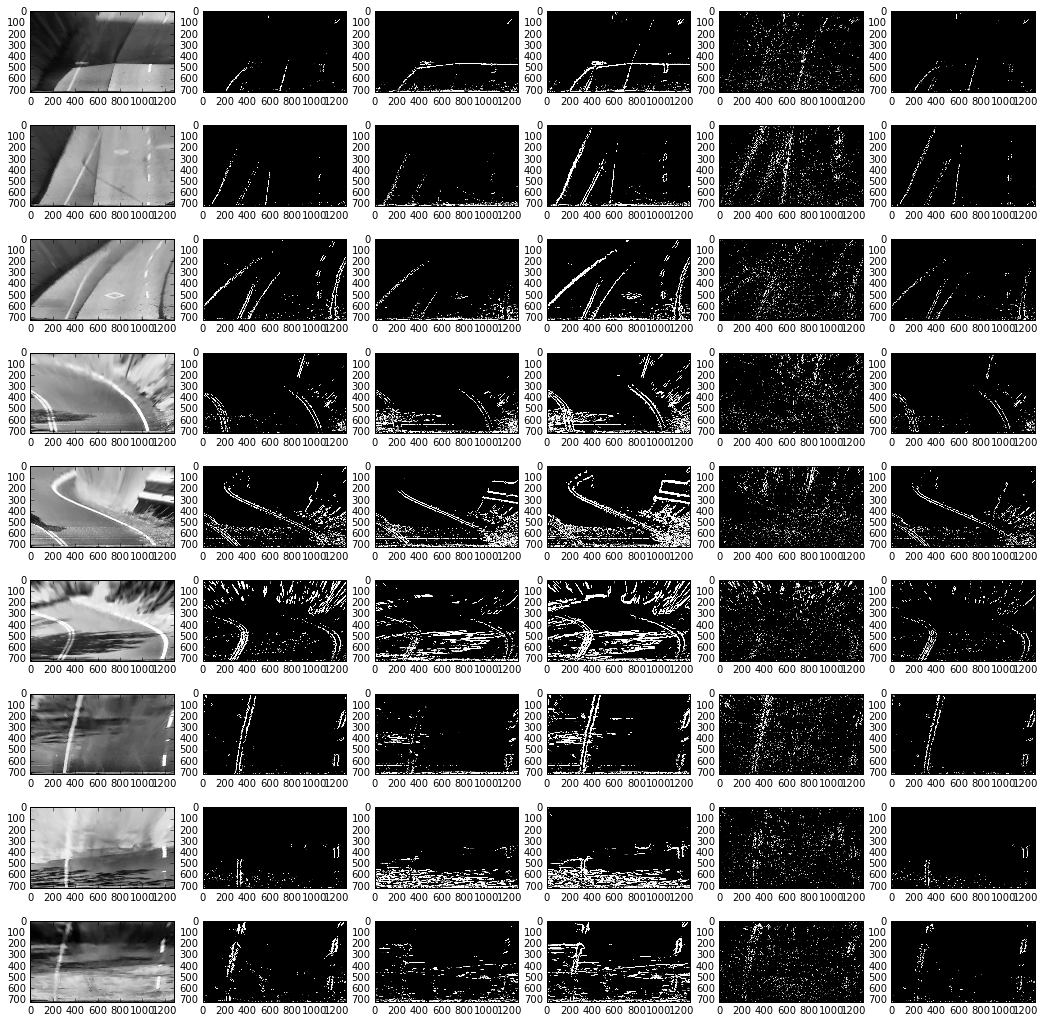

In [74]:
fig = plt.figure(figsize=(18, 18))
gs = gridspec.GridSpec(9, 6)

for i, img_nm in enumerate(glob.iglob('./test_images/vlcsnap*jpg')):
    img = cv2.imread(img_nm,0)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
   
    warped = cv2.warpPerspective(img, road_camera_M, img_size, flags=cv2.INTER_LANCZOS4)
    ax = plt.subplot(gs[i * 6])
    plt.imshow(warped, cmap='gray')

    sobel_x = abs_sobel_thresh(warped, orient='x', sobel_kernel=5, thresh=(20, 150))
    sobel_y = abs_sobel_thresh(warped, orient='y', sobel_kernel=5, thresh=(15, 150))
    mag_binary = mag_threshold(warped, sobel_kernel=5, mag_thresh=(15, 80))
    dir_binary = dir_threshold(warped, sobel_kernel=3, thresh=(0.01, 0.3))

    ax = plt.subplot(gs[i * 6 + 1])
    plt.imshow(sobel_x, cmap='gray')
    
    ax = plt.subplot(gs[i * 6 + 2])
    plt.imshow(sobel_y, cmap='gray')
    
    ax = plt.subplot(gs[i * 6 + 3])
    plt.imshow(mag_binary, cmap='gray')
    
    ax = plt.subplot(gs[i * 6 + 4])
    plt.imshow(dir_binary, cmap='gray')
    
    combined = np.zeros_like(gray)
    combined[((sobel_x == 1) & (sobel_y == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    ax = plt.subplot(gs[i * 6 + 5])
    plt.imshow(combined, cmap='gray')


## Pipeline
We now have perspective corrected images that can be entered into a lane detection pipeline. The pipeline first converts the image to HSV colorspace and extracts the saturation. Next it performs a camera correction and perspective correction. Then the Sobol thresholds are computed to come up with a binary image. The final step consists of identifying the lanes by means of histograms. The pipeline shows the saturation of th image, the boxes on the binary image with the boxes and the lanes and finally a polygon on the original image that shows where the car can drive.

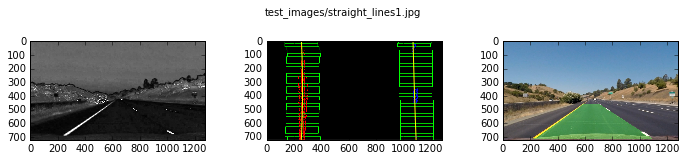

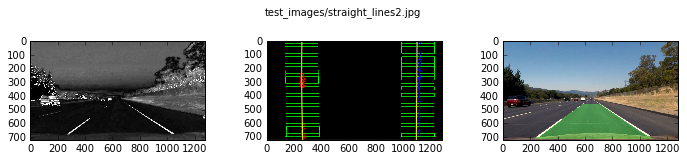

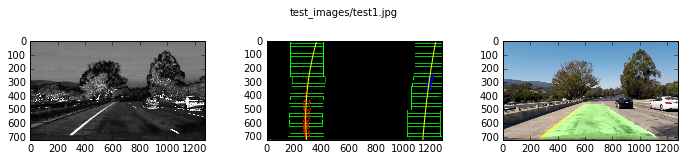

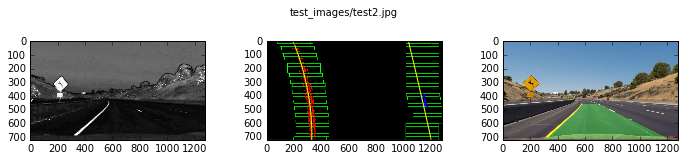

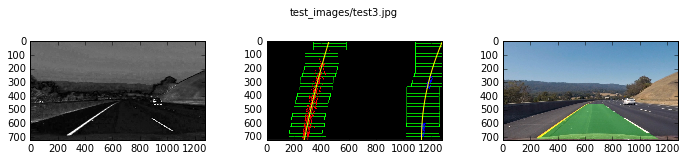

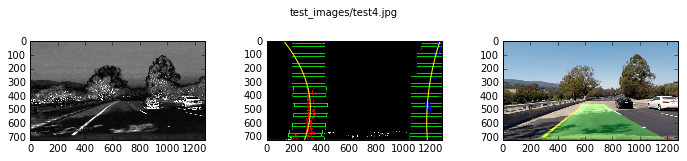

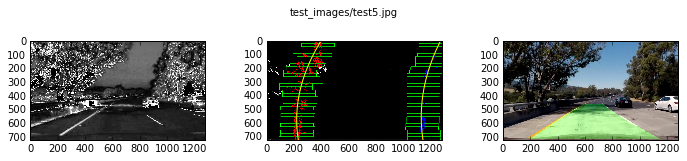

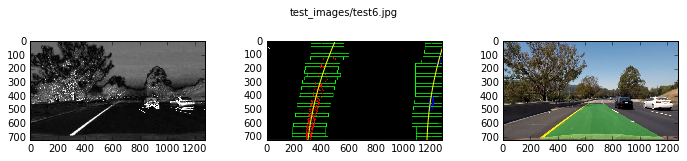

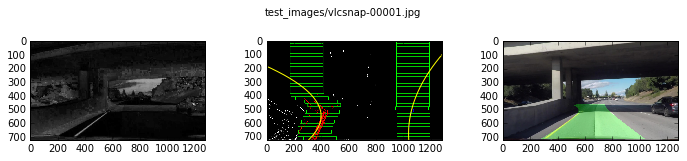

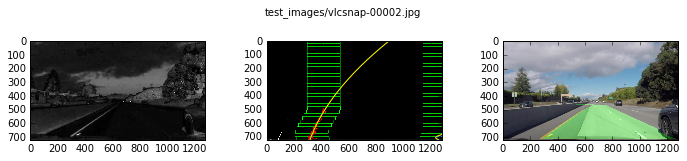

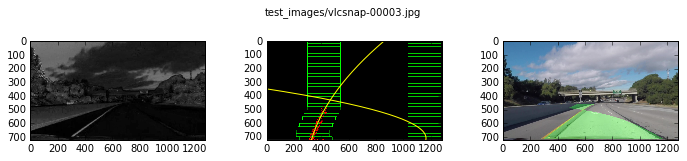

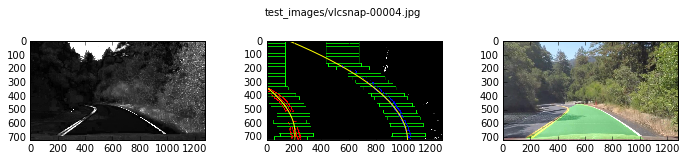

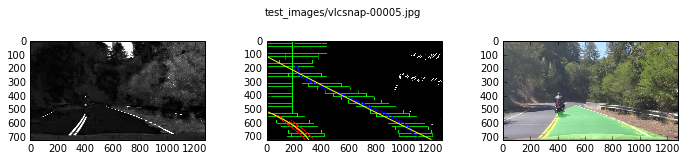

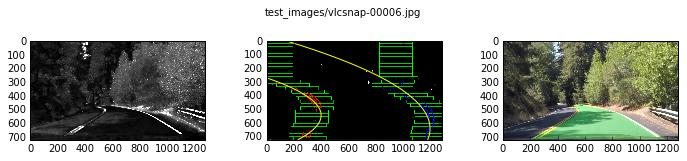

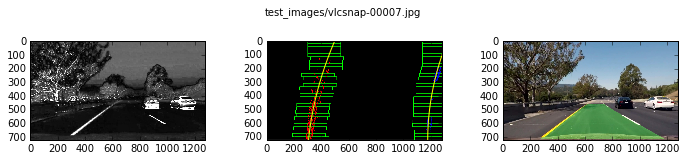

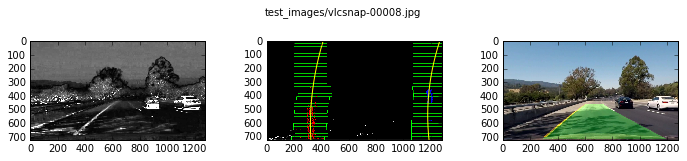

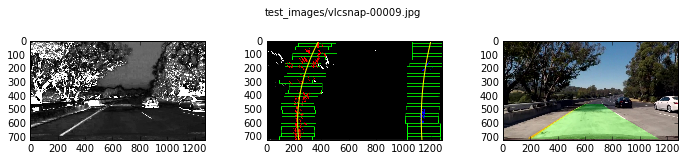

In [118]:
# Let's build the entire pipeline at once
def pipeline_one(filename):
    img = cv2.imread(filename)
    # Saturation channel
    saturation = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    # Get the image size.
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    #ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, saturation.shape[::-1], None,None)
   
    # Undistort the image
    undist_sat = cv2.undistort(saturation, mtx, dist, None, mtx)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Perform perspective transform
    img_size = (undist.shape[1], undist.shape[0])
    warped = cv2.warpPerspective(undist_sat, road_camera_M, img_size, flags=cv2.INTER_LINEAR)
 
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(warped, orient='x', sobel_kernel=5, thresh=(20, 150))
    grady = abs_sobel_thresh(warped, orient='y', sobel_kernel=5, thresh=(15, 150))
    mag_binary = mag_threshold(warped, sobel_kernel=5, mag_thresh=(15, 80))
    dir_binary = dir_threshold(warped, sobel_kernel=3, thresh=(0.01, 0.3))

    binary_warped = np.zeros_like(saturation)
    binary_warped[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
   
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 30
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 120
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2) 
       
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
 
    # Create an output image to draw on and  visualize the result
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, inv_road_camera_M, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    fig = plt.figure(figsize=(12,6))
    fig.suptitle(fname)
    plt.subplot(331)
    plt.imshow(saturation, cmap="gray")
 
    plt.subplot(332)
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
  
    plt.subplot(333)
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    
    
    

images=glob.glob("test_images/*.jpg")
for idx, fname in enumerate(images):
    pipeline_one(fname)


We see that the filters are working reasonable on most normal lighting conditions. On the images with shadows or with uneven road color we see that the performance is not that great. Next we will create series for the angle of the left line and the right line. We also add the Y channel in the YCrCb color space. This is comparable to the grayscale of an image.

In [119]:
l_a = []
l_b = []
l_c = []
r_a = []
r_b = []
r_c = []

# Let's build the entire pipeline at once
def movie_pipeline_one(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Saturation channel
    saturation = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    Y_chan = cv2.cvtColor(img, cv2.COLOR_RGB2YCR_CB)[:,:,0]
    # Get the image size.
    img_size = (img.shape[1], img.shape[0])

    # Undistort the image
    undist_sat = cv2.undistort(saturation, mtx, dist, None, mtx)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    undist_Y = cv2.undistort(Y_chan, mtx, dist, None, mtx)
    # Perform perspective transform
    img_size = (undist.shape[1], undist.shape[0])
    warped = cv2.warpPerspective(undist_sat, road_camera_M, img_size, flags=cv2.INTER_LINEAR)
    warped_Y = cv2.warpPerspective(undist_Y, road_camera_M, img_size, flags=cv2.INTER_LINEAR)
 
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(warped, orient='x', sobel_kernel=5, thresh=(20, 150))
    grady = abs_sobel_thresh(warped, orient='y', sobel_kernel=5, thresh=(15, 150))
    mag_binary = mag_threshold(warped, sobel_kernel=5, mag_thresh=(15, 80))
    dir_binary = dir_threshold(warped, sobel_kernel=3, thresh=(0.01, 0.3))
   
    gradx_Y = abs_sobel_thresh(warped_Y, orient='x', sobel_kernel=5, thresh=(20, 150))
    grady_Y = abs_sobel_thresh(warped_Y, orient='y', sobel_kernel=5, thresh=(15, 150))
    mag_binary_Y = mag_threshold(warped_Y, sobel_kernel=5, mag_thresh=(15, 80))
    dir_binary_Y = dir_threshold(warped_Y, sobel_kernel=3, thresh=(0.01, 0.3))

    binary_warped = np.zeros_like(saturation)
    binary_warped[(((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) |
                   ((gradx_Y == 1) & (grady_Y == 1)) | ((mag_binary_Y == 1) & (dir_binary_Y == 1)))] = 1
    
   
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 30
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 120
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
 
    def curv(poly):
        y_eval = img[:,:,0].shape[1]
        return ((1 + (2*poly[0]*y_eval + poly[1])**2)**1.5) / np.absolute(2*poly[0])
 
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    left_curve = curv(left_fit)
    right_fit = np.polyfit(righty, rightx, 2) 
    right_curve = curv(right_fit)
    l_a.append(left_fit[0])
    l_b.append(left_fit[1])
    l_c.append(left_fit[2])
    r_a.append(right_fit[0])
    r_b.append(right_fit[1])
    r_c.append(right_fit[2])
    
       
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
 
    # Create an output image to draw on and  visualize the result
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, inv_road_camera_M, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
 
    return cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(38, 45)
white_clip = clip1.fl_image(movie_pipeline_one) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
 
 

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4



 99%|█████████▉| 175/176 [01:03<00:00,  2.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 1min 5s, sys: 14 s, total: 1min 19s
Wall time: 1min 4s


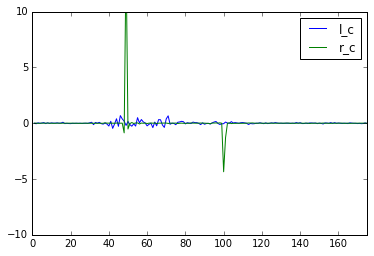

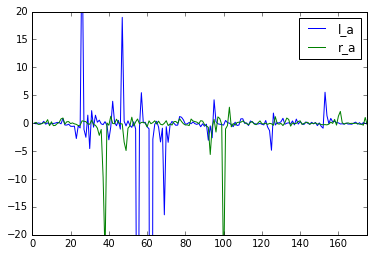

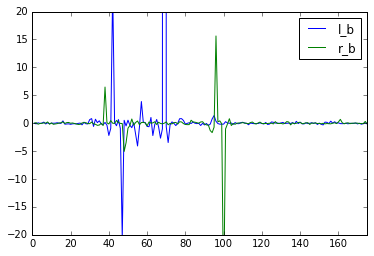

In [120]:
import pandas as pd
series_c = pd.DataFrame({'l_c': l_c, 
                         'r_c': r_c})
plt.figure()
series_c.pct_change().plot(ylim=(-10,10))

series_a = pd.DataFrame({'l_a': l_a, 
                         'r_a': r_a})
plt.figure()
series_a.pct_change().plot(ylim=(-20,20))

series_b = pd.DataFrame({'l_b': l_b, 
                         'r_b': r_b})
plt.figure()
series_b.pct_change().plot(ylim=(-20,20))

We clearly see outliers in the time series. To overcome these large outliers we compute the percentage change between the new value and the old value. If that exceeds respectively 20, 20 and 5 percentage for a, b and c we will use the previous value. 

In [122]:
l_a = []
l_b = []
l_c = []
r_a = []
r_b = []
r_c = []
prev_l = [float('NaN'), float('NaN'), float('NaN')]
prev_r = [float('NaN'), float('NaN'), float('NaN')]
limits = [20, 20, 5]
# Let's build the entire pipeline at once
def movie_pipeline_two(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Saturation channel
    saturation = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    Y_chan = cv2.cvtColor(img, cv2.COLOR_RGB2YCR_CB)[:,:,0]
    # Get the image size.
    img_size = (img.shape[1], img.shape[0])

    # Undistort the image
    undist_sat = cv2.undistort(saturation, mtx, dist, None, mtx)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    undist_Y = cv2.undistort(Y_chan, mtx, dist, None, mtx)
    # Perform perspective transform
    img_size = (undist.shape[1], undist.shape[0])
    warped = cv2.warpPerspective(undist_sat, road_camera_M, img_size, flags=cv2.INTER_LINEAR)
    warped_Y = cv2.warpPerspective(undist_Y, road_camera_M, img_size, flags=cv2.INTER_LINEAR)

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(warped, orient='x', sobel_kernel=ksize, thresh=(10, 100))
    grady = abs_sobel_thresh(warped, orient='y', sobel_kernel=ksize, thresh=(10, 100))
    mag_binary = mag_threshold(warped, sobel_kernel=ksize, mag_thresh=(10, 100))
    dir_binary = dir_threshold(warped, sobel_kernel=ksize, thresh=(0.5, 1.3))
    
    gradx_Y = abs_sobel_thresh(warped_Y, orient='x', sobel_kernel=5, thresh=(20, 150))
    grady_Y = abs_sobel_thresh(warped_Y, orient='y', sobel_kernel=5, thresh=(15, 150))
    mag_binary_Y = mag_threshold(warped_Y, sobel_kernel=5, mag_thresh=(15, 80))
    dir_binary_Y = dir_threshold(warped_Y, sobel_kernel=3, thresh=(0.01, 0.3))

    binary_warped = np.zeros_like(saturation)
    binary_warped[(((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) |
                   ((gradx_Y == 1) & (grady_Y == 1)) | ((mag_binary_Y == 1) & (dir_binary_Y == 1)))] = 1
   
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 30
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 120
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
 
    def curv(poly):
        y_eval = img[:,:,0].shape[1]
        return ((1 + (2*poly[0]*y_eval + poly[1])**2)**1.5) / np.absolute(2*poly[0])
 
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2) 
   
    for i in range(3):
        if abs((left_fit[i] - prev_l[i]) / prev_l[i]) > limits[i]:
            left_fit[i] = prev_l[i]
        else:
            prev_l[i] = left_fit[i]
        if abs((right_fit[i] - prev_r[i]) / prev_r[i]) > limits[i]:
            right_fit[i] = prev_r[i]
        else:
            prev_r[i] = right_fit[i]
    
    l_a.append(left_fit[0])
    l_b.append(left_fit[1])
    l_c.append(left_fit[2])
    r_a.append(right_fit[0])
    r_b.append(right_fit[1])
    r_c.append(right_fit[2])
       
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
 
    # Create an output image to draw on and  visualize the result
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, inv_road_camera_M, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
 
    return cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(38, 45)
white_clip = clip1.fl_image(movie_pipeline_two) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
 

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4



 99%|█████████▉| 175/176 [01:04<00:00,  2.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 1min 7s, sys: 14.5 s, total: 1min 21s
Wall time: 1min 5s


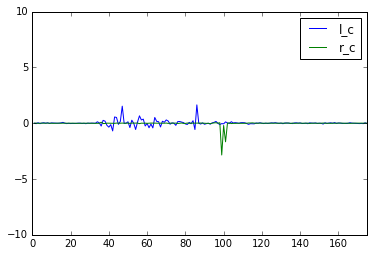

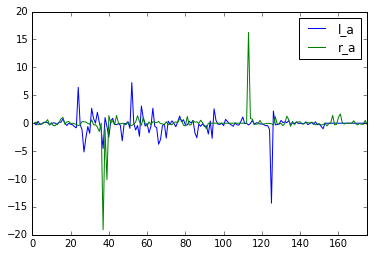

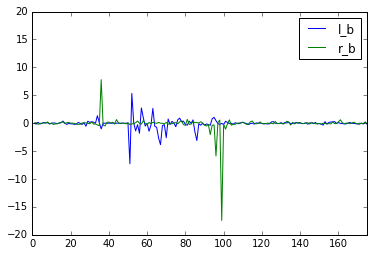

In [123]:
series_c = pd.DataFrame({'l_c': l_c, 
                         'r_c': r_c})
plt.figure()
series_c.pct_change().plot(ylim=(-10,10))

series_a = pd.DataFrame({'l_a': l_a, 
                         'r_a': r_a})
plt.figure()
series_a.pct_change().plot(ylim=(-20,20))

series_b = pd.DataFrame({'l_b': l_b, 
                         'r_b': r_b})
plt.figure()
series_b.pct_change().plot(ylim=(-20,20))

Unfortunately the new fitted line is still not good enough. Instead of doing piecewise comparison we will compare whether any coefficient in the polynomial is an outlier. If that is the case we will keep the information from the last frame.

In [124]:
l_a = []
l_b = []
l_c = []
r_a = []
r_b = []
r_c = []
prev_l = [float('NaN'), float('NaN'), float('NaN')]
prev_r = [float('NaN'), float('NaN'), float('NaN')]
# Let's build the entire pipeline at once
def movie_pipeline_three(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Saturation channel
    saturation = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    Y_chan = cv2.cvtColor(img, cv2.COLOR_RGB2YCR_CB)[:,:,0]
    # Get the image size.
    img_size = (img.shape[1], img.shape[0])

    # Undistort the image
    undist_sat = cv2.undistort(saturation, mtx, dist, None, mtx)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    undist_Y = cv2.undistort(Y_chan, mtx, dist, None, mtx)
    # Perform perspective transform
    img_size = (undist.shape[1], undist.shape[0])
    warped = cv2.warpPerspective(undist_sat, road_camera_M, img_size, flags=cv2.INTER_LINEAR)
    warped_Y = cv2.warpPerspective(undist_Y, road_camera_M, img_size, flags=cv2.INTER_LINEAR)

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(warped, orient='x', sobel_kernel=ksize, thresh=(10, 100))
    grady = abs_sobel_thresh(warped, orient='y', sobel_kernel=ksize, thresh=(10, 100))
    mag_binary = mag_threshold(warped, sobel_kernel=ksize, mag_thresh=(10, 100))
    dir_binary = dir_threshold(warped, sobel_kernel=ksize, thresh=(0.5, 1.3))
    
    gradx_Y = abs_sobel_thresh(warped_Y, orient='x', sobel_kernel=5, thresh=(20, 150))
    grady_Y = abs_sobel_thresh(warped_Y, orient='y', sobel_kernel=5, thresh=(15, 150))
    mag_binary_Y = mag_threshold(warped_Y, sobel_kernel=5, mag_thresh=(15, 80))
    dir_binary_Y = dir_threshold(warped_Y, sobel_kernel=3, thresh=(0.01, 0.3))

    binary_warped = np.zeros_like(saturation)
    binary_warped[(((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) |
                   ((gradx_Y == 1) & (grady_Y == 1)) | ((mag_binary_Y == 1) & (dir_binary_Y == 1)))] = 1
   
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 30
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 120
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
 
    def curv(poly):
        y_eval = img[:,:,0].shape[1]
        return ((1 + (2*poly[0]*y_eval + poly[1])**2)**1.5) / np.absolute(2*poly[0])
 
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2) 
   
    if (abs((left_fit[0] - prev_l[0]) / prev_l[0]) > 12 or 
        abs((left_fit[1] - prev_l[1]) / prev_l[1]) > 12 or 
        abs((left_fit[2] - prev_l[2]) / prev_l[2]) > 10): 
        left_fit[0] = prev_l[0]
        left_fit[1] = prev_l[1]
        left_fit[2] = prev_l[2]
    else:
        prev_l[0] = left_fit[0]
        prev_l[1] = left_fit[1]
        prev_l[2] = left_fit[2]
        
    if (abs((right_fit[0] - prev_r[0]) / prev_r[0]) > 12 or 
        abs((right_fit[1] - prev_r[1]) / prev_r[1]) > 12 or 
        abs((right_fit[2] - prev_r[2]) / prev_r[2]) > 10): 
        right_fit[0] = prev_r[0]
        right_fit[1] = prev_r[1]
        right_fit[2] = prev_r[2]
    else:
        prev_r[0] = right_fit[0]
        prev_r[1] = right_fit[1]
        prev_r[2] = right_fit[2]
        

    l_a.append(left_fit[0])
    l_b.append(left_fit[1])
    l_c.append(left_fit[2])
    r_a.append(right_fit[0])
    r_b.append(right_fit[1])
    r_c.append(right_fit[2])
       
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
 
    # Create an output image to draw on and  visualize the result
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, inv_road_camera_M, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
 
    return cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'project_video_out_three.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(38, 45)
white_clip = clip1.fl_image(movie_pipeline_three) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
 

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4



 99%|█████████▉| 175/176 [01:01<00:00,  2.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 1min 4s, sys: 13.2 s, total: 1min 17s
Wall time: 1min 2s


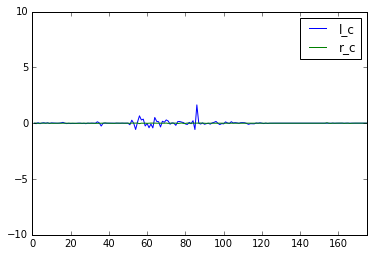

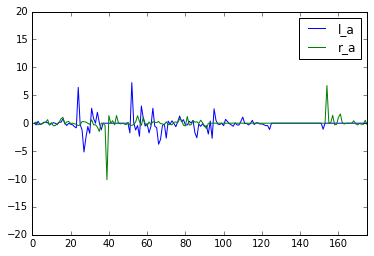

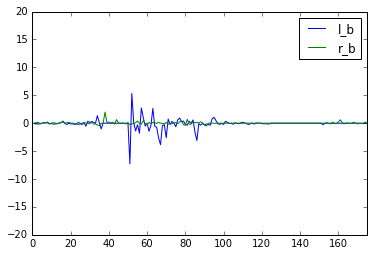

In [125]:
series_c = pd.DataFrame({'l_c': l_c, 
                         'r_c': r_c})
plt.figure()
series_c.pct_change().plot(ylim=(-10,10))

series_a = pd.DataFrame({'l_a': l_a, 
                         'r_a': r_a})
plt.figure()
series_a.pct_change().plot(ylim=(-20,20))

series_b = pd.DataFrame({'l_b': l_b, 
                         'r_b': r_b})
plt.figure()
series_b.pct_change().plot(ylim=(-20,20))

This is already much better. The last step that we will perform is smoothing over the past 5 estimations.

In [10]:
l_a = []
l_b = []
l_c = []
r_a = []
r_b = []
r_c = []
prev_l = [float('NaN'), float('NaN'), float('NaN')]
prev_r = [float('NaN'), float('NaN'), float('NaN')]
prev_l_a = []
prev_r_a = []

# Let's build the entire pipeline at once
def movie_pipeline_four(img):
    global prev_l
    global prev_r
    global prev_l_a
    global prev_r_a
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Saturation channel
    saturation = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    Y_chan = cv2.cvtColor(img, cv2.COLOR_RGB2YCR_CB)[:,:,0]
    # Get the image size.
    img_size = (img.shape[1], img.shape[0])

    # Undistort the image
    undist_sat = cv2.undistort(saturation, mtx, dist, None, mtx)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    undist_Y = cv2.undistort(Y_chan, mtx, dist, None, mtx)
    # Perform perspective transform
    img_size = (undist.shape[1], undist.shape[0])
    warped = cv2.warpPerspective(undist_sat, road_camera_M, img_size, flags=cv2.INTER_LINEAR)
    warped_Y = cv2.warpPerspective(undist_Y, road_camera_M, img_size, flags=cv2.INTER_LINEAR)

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(warped, orient='x', sobel_kernel=ksize, thresh=(20, 150))
    grady = abs_sobel_thresh(warped, orient='y', sobel_kernel=ksize, thresh=(15, 150))
    mag_binary = mag_threshold(warped, sobel_kernel=ksize, mag_thresh=(15, 80))
    dir_binary = dir_threshold(warped, sobel_kernel=ksize, thresh=(0.01, 0.3))
    
    gradx_Y = abs_sobel_thresh(warped_Y, orient='x', sobel_kernel=5, thresh=(20, 150))
    grady_Y = abs_sobel_thresh(warped_Y, orient='y', sobel_kernel=5, thresh=(15, 150))
    mag_binary_Y = mag_threshold(warped_Y, sobel_kernel=5, mag_thresh=(15, 80))
    dir_binary_Y = dir_threshold(warped_Y, sobel_kernel=3, thresh=(0.01, 0.3))

    binary_warped = np.zeros_like(saturation)
    binary_warped[(((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) |
                   ((gradx_Y == 1) & (grady_Y == 1)) | ((mag_binary_Y == 1) & (dir_binary_Y == 1)))] = 1
   
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 30
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 120
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
 
    def curv(poly):
        y_eval = img[:,:,0].shape[1]
        return ((1 + (2*poly[0]*y_eval + poly[1])**2)**1.5) / np.absolute(2*poly[0])
 
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2) 
    
    if (abs((left_fit[0] - prev_l[0]) / prev_l[0]) > 12 or 
        abs((left_fit[1] - prev_l[1]) / prev_l[1]) > 12 or 
        abs((left_fit[2] - prev_l[2]) / prev_l[2]) > 10): 
        left_fit = prev_l
    
    if len(prev_l_a) > 10:
        prev_l_a.pop(0)
       
    prev_l_a.append(np.array(left_fit))
    left_fit = np.stack(prev_l_a).mean(axis=0)
    prev_l = left_fit
        

    if (abs((right_fit[0] - prev_r[0]) / prev_r[0]) > 12 or 
        abs((right_fit[1] - prev_r[1]) / prev_r[1]) > 12 or 
        abs((right_fit[2] - prev_r[2]) / prev_r[2]) > 10): 
        right_fit = prev_r
    
    if len(prev_r_a) > 10:
        prev_r_a.pop(0)
       
    prev_r_a.append(np.array(right_fit))
    right_fit = np.stack(prev_r_a).mean(axis=0)
    prev_r = right_fit

    l_a.append(left_fit[0])
    l_b.append(left_fit[1])
    l_c.append(left_fit[2])
    r_a.append(right_fit[0])
    r_b.append(right_fit[1])
    r_c.append(right_fit[2])
       
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
 
    # Create an output image to draw on and  visualize the result
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, inv_road_camera_M, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
 
    return cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'project_video_out_four.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(38, 45)
white_clip = clip1.fl_image(movie_pipeline_four) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
 

c:\tools\anaconda3\lib\site-packages\moviepy\audio\io\readers.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.nchannels))



MoviePy: building video file project_video_out_four.mp4
----------------------------------------

Writing video into project_video_out_four.mp4
|----------| 0/169   0% [elapsed: 00:00 left: ?, ? iters/sec]

c:\tools\anaconda3\lib\site-packages\ipykernel\__main__.py:51: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


|----------| 1/169   0% [elapsed: 00:00 left: 01:39,  1.69 iters/sec]

c:\tools\anaconda3\lib\site-packages\ipykernel\__main__.py:51: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Done writing video in project_video_out_four.mp4 !
Your video is ready !
Wall time: 1min 19s


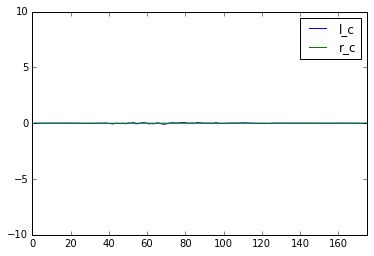

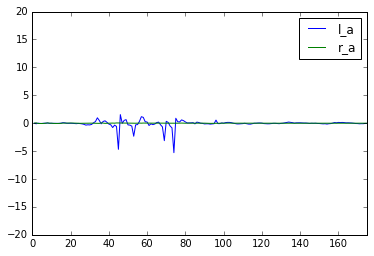

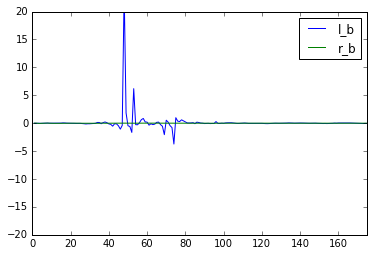

In [156]:
series_c = pd.DataFrame({'l_c': l_c, 
                         'r_c': r_c})
plt.figure()
series_c.pct_change().plot(ylim=(-10,10))

series_a = pd.DataFrame({'l_a': l_a, 
                         'r_a': r_a})
plt.figure()
series_a.pct_change().plot(ylim=(-20,20))

series_b = pd.DataFrame({'l_b': l_b, 
                         'r_b': r_b})
plt.figure()
series_b.pct_change().plot(ylim=(-20,20))

Last thing that needs to be done is adding the current curvature of the road.

In [11]:
prev_l = [float('NaN'), float('NaN'), float('NaN')]
prev_r = [float('NaN'), float('NaN'), float('NaN')]
prev_l_a = []
prev_r_a = []
prev_rl = [float('NaN'), float('NaN'), float('NaN')]
prev_rr = [float('NaN'), float('NaN'), float('NaN')]
prev_rl_a = []
prev_rr_a = []

left_h = []
right_h = []

# Let's build the entire pipeline at once
def movie_pipeline_five(img):
    global prev_l
    global prev_r
    global prev_l_a
    global prev_r_a
    global prev_rl
    global prev_rr
    global prev_rl_a
    global prev_rr_a
     
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Saturation channel
    saturation = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    Y_chan = cv2.cvtColor(img, cv2.COLOR_RGB2YCR_CB)[:,:,0]
    # Get the image size.
    img_size = (img.shape[1], img.shape[0])

    # Undistort the image
    undist_sat = cv2.undistort(saturation, mtx, dist, None, mtx)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    undist_Y = cv2.undistort(Y_chan, mtx, dist, None, mtx)
    # Perform perspective transform
    img_size = (undist.shape[1], undist.shape[0])
    warped = cv2.warpPerspective(undist_sat, road_camera_M, img_size, flags=cv2.INTER_LINEAR)
    warped_Y = cv2.warpPerspective(undist_Y, road_camera_M, img_size, flags=cv2.INTER_LINEAR)

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(warped, orient='x', sobel_kernel=ksize, thresh=(20, 150))
    grady = abs_sobel_thresh(warped, orient='y', sobel_kernel=ksize, thresh=(15, 150))
    mag_binary = mag_threshold(warped, sobel_kernel=ksize, mag_thresh=(15, 80))
    dir_binary = dir_threshold(warped, sobel_kernel=ksize, thresh=(0.01, 0.3))
    
    gradx_Y = abs_sobel_thresh(warped_Y, orient='x', sobel_kernel=5, thresh=(20, 150))
    grady_Y = abs_sobel_thresh(warped_Y, orient='y', sobel_kernel=5, thresh=(15, 150))
    mag_binary_Y = mag_threshold(warped_Y, sobel_kernel=5, mag_thresh=(15, 80))
    dir_binary_Y = dir_threshold(warped_Y, sobel_kernel=3, thresh=(0.01, 0.3))

    binary_warped = np.zeros_like(saturation)
    binary_warped[(((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) |
                   ((gradx_Y == 1) & (grady_Y == 1)) | ((mag_binary_Y == 1) & (dir_binary_Y == 1)))] = 1
   
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 30
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 120
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
 
    def curv(poly):
        y_eval = img[:,:,0].shape[1]
        return ((1 + (2*poly[0]*y_eval + poly[1])**2)**1.5) / np.absolute(2*poly[0])
   
# Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
   
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2) 
    
    if (abs((left_fit[0] - prev_l[0]) / prev_l[0]) > 12 or 
        abs((left_fit[1] - prev_l[1]) / prev_l[1]) > 12 or 
        abs((left_fit[2] - prev_l[2]) / prev_l[2]) > 10): 
        left_fit = prev_l
    
    if len(prev_l_a) > 10:
        prev_l_a.pop(0)
       
    prev_l_a.append(np.array(left_fit))
    left_fit = np.stack(prev_l_a).mean(axis=0)
    prev_l = left_fit
        

    if (abs((right_fit[0] - prev_r[0]) / prev_r[0]) > 12 or 
        abs((right_fit[1] - prev_r[1]) / prev_r[1]) > 12 or 
        abs((right_fit[2] - prev_r[2]) / prev_r[2]) > 10): 
        right_fit = prev_r
    
    if len(prev_r_a) > 10:
        prev_r_a.pop(0)
       
    prev_r_a.append(np.array(right_fit))
    right_fit = np.stack(prev_r_a).mean(axis=0)
    prev_r = right_fit

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    if (abs((left_fit_cr[0] - prev_rl[0]) / prev_rl[0]) > 10 or 
        abs((left_fit_cr[1] - prev_rl[1]) / prev_rl[1]) > 10 or 
        abs((left_fit_cr[2] - prev_rl[2]) / prev_rl[2]) > 10): 
        left_fit_cr = prev_rl
    
    if len(prev_rl_a) > 11:
        prev_rl_a.pop(0)
       
    prev_l_a.append(np.array(left_fit_cr))
    left_fit_cr = np.stack(prev_l_a).mean(axis=0)
    prev_l = left_fit_cr

    if (abs((right_fit_cr[0] - prev_rr[0]) / prev_rr[0]) > 10 or 
        abs((right_fit_cr[1] - prev_rr[1]) / prev_rr[1]) > 10 or 
        abs((right_fit_cr[2] - prev_rr[2]) / prev_rr[2]) > 10): 
        right_fit_cr = prev_rr
    
    if len(prev_rr_a) > 11:
        prev_rr_a.pop(0)
       
    prev_rr_a.append(np.array(right_fit_cr))
    right_fit_cr = np.stack(prev_rr_a).mean(axis=0)
    prev_rr = right_fit_cr
   
    left_curvad = curv(left_fit_cr)
    right_curvad = curv(right_fit_cr)
    # Relative location of car.
    curv = (left_curvad + right_curvad) / 2.0
    loc_car = left_curvad - right_curvad
    
    dash_str = ('Radius of curvature %s (m)\nVehicle is %sm left from center' % 
                (round(curv), round(loc_car, 1)))
    
    
    # Create an output image to draw on and  visualize the result
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, inv_road_camera_M, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
 
    cv2.putText(result, dash_str ,(1,30), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
    return cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'project_video_out_five.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(38, 45)
white_clip = clip1.fl_image(movie_pipeline_five) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
 

c:\tools\anaconda3\lib\site-packages\moviepy\audio\io\readers.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.nchannels))



MoviePy: building video file project_video_out_five.mp4
----------------------------------------

Writing video into project_video_out_five.mp4
|----------| 0/169   0% [elapsed: 00:00 left: ?, ? iters/sec]

c:\tools\anaconda3\lib\site-packages\ipykernel\__main__.py:56: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
c:\tools\anaconda3\lib\site-packages\ipykernel\__main__.py:56: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Done writing video in project_video_out_five.mp4 !
Your video is ready !
Wall time: 1min 20s


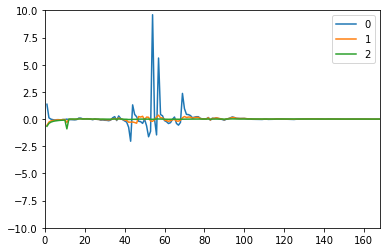

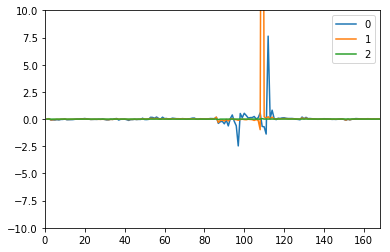

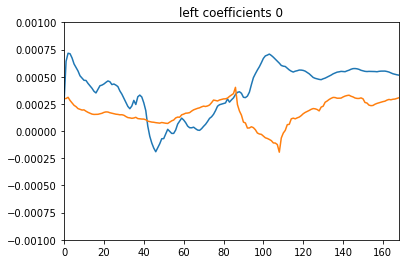

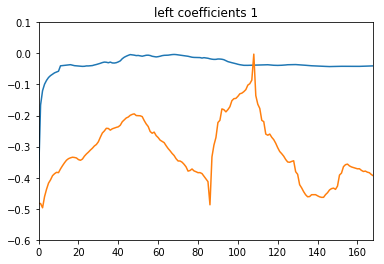

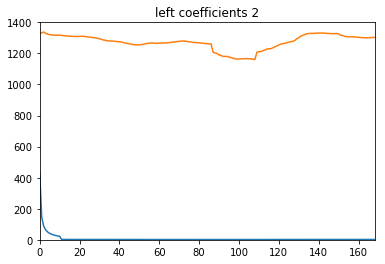

In [8]:
import pandas as pd

series_l = pd.DataFrame(left_h)
series_r = pd.DataFrame(right_h)
plt.figure()
series_l.pct_change().plot(ylim=(-10,10))

plt.figure()
series_r.pct_change().plot(ylim=(-10,10))

plt.figure()
series_l.loc[:,0].plot(ylim=(-1e-3,1e-3), title='left coefficients 0')
series_r.loc[:,0].plot(ylim=(-1e-3,1e-3))
plt.figure()
series_l.loc[:,1].plot(ylim=(-0.6,.1), title='left coefficients 1')
series_r.loc[:,1].plot(ylim=(-0.6,.1))
plt.figure()
series_l.loc[:,2].plot(ylim=(0,1400), title='left coefficients 2')
series_r.loc[:,2].plot(ylim=(0,1400))


In [ ]:

white_output = 'project_video_out_full.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(movie_pipeline_five) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_out_full.mp4
[MoviePy] Writing video project_video_out_full.mp4





  0%|          | 0/1261 [00:00<?, ?it/s]


  0%|          | 1/1261 [00:00<07:33,  2.78it/s]


  0%|          | 2/1261 [00:00<07:39,  2.74it/s]


  0%|          | 3/1261 [00:01<07:30,  2.79it/s]


  0%|          | 4/1261 [00:01<07:17,  2.87it/s]


  0%|          | 5/1261 [00:01<07:04,  2.96it/s]


  0%|          | 6/1261 [00:02<06:57,  3.00it/s]


  1%|          | 7/1261 [00:02<06:49,  3.07it/s]


  1%|          | 8/1261 [00:02<06:47,  3.07it/s]


  1%|          | 9/1261 [00:02<06:44,  3.09it/s]


  1%|          | 10/1261 [00:03<06:47,  3.07it/s]


  1%|          | 11/1261 [00:03<06:46,  3.07it/s]


  1%|          | 12/1261 [00:04<07:09,  2.91it/s]


  1%|          | 13/1261 [00:04<07:15,  2.87it/s]


  1%|          | 14/1261 [00:04<07:37,  2.73it/s]


  1%|          | 15/1261 [00:05<07:31,  2.76it/s]


  1%|▏         | 16/1261 [00:05<07:21,  2.82it/s]


  1%|▏         | 17/1261 [00:05<07:08,  2.91it/s]


  1%|▏         | 18/1261 [00:06<07:04,  2.93it/s]


  2%|▏         | 19/1261 [0

Two things that remain to be improved is a better estimation of the car location and the curvature of the road.

In [8]:
l_a = []
l_b = []
l_c = []
r_a = []
r_b = []
r_c = []
prev_l = [float('NaN'), float('NaN'), float('NaN')]
prev_r = [float('NaN'), float('NaN'), float('NaN')]
prev_l_a = []
prev_r_a = []
prev_rl = [float('NaN'), float('NaN'), float('NaN')]
prev_rr = [float('NaN'), float('NaN'), float('NaN')]
prev_rl_a = []
prev_rr_a = []


# Let's build the entire pipeline at once
def movie_pipeline_five(img):
    global prev_l
    global prev_r
    global prev_l_a
    global prev_r_a
    global prev_rl
    global prev_rr
    global prev_rl_a
    global prev_rr_a

    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Saturation channel
    saturation = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    Y_chan = cv2.cvtColor(img, cv2.COLOR_RGB2YCR_CB)[:,:,0]
    # Get the image size.
    img_size = (img.shape[1], img.shape[0])

    # Undistort the image
    undist_sat = cv2.undistort(saturation, mtx, dist, None, mtx)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    undist_Y = cv2.undistort(Y_chan, mtx, dist, None, mtx)
    # Perform perspective transform
    img_size = (undist.shape[1], undist.shape[0])
    warped = cv2.warpPerspective(undist_sat, road_camera_M, img_size, flags=cv2.INTER_LINEAR)
    warped_Y = cv2.warpPerspective(undist_Y, road_camera_M, img_size, flags=cv2.INTER_LINEAR)

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(warped, orient='x', sobel_kernel=ksize, thresh=(20, 150))
    grady = abs_sobel_thresh(warped, orient='y', sobel_kernel=ksize, thresh=(15, 150))
    mag_binary = mag_threshold(warped, sobel_kernel=ksize, mag_thresh=(15, 80))
    dir_binary = dir_threshold(warped, sobel_kernel=ksize, thresh=(0.01, 0.3))
    
    gradx_Y = abs_sobel_thresh(warped_Y, orient='x', sobel_kernel=5, thresh=(20, 150))
    grady_Y = abs_sobel_thresh(warped_Y, orient='y', sobel_kernel=5, thresh=(15, 150))
    mag_binary_Y = mag_threshold(warped_Y, sobel_kernel=5, mag_thresh=(15, 80))
    dir_binary_Y = dir_threshold(warped_Y, sobel_kernel=3, thresh=(0.01, 0.3))

    binary_warped = np.zeros_like(saturation)
    binary_warped[(((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) |
                   ((gradx_Y == 1) & (grady_Y == 1)) | ((mag_binary_Y == 1) & (dir_binary_Y == 1)))] = 1
   
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 30
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 120
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
 
    def curv(poly):
        y_eval = img[:,:,0].shape[1]
        return ((1 + (2*poly[0]*y_eval + poly[1])**2)**1.5) / np.absolute(2*poly[0])
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
 
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2) 
    
    if (abs((left_fit[0] - prev_l[0]) / prev_l[0]) > 12 or 
        abs((left_fit[1] - prev_l[1]) / prev_l[1]) > 12 or 
        abs((left_fit[2] - prev_l[2]) / prev_l[2]) > 10): 
        left_fit = prev_l
    
    if len(prev_l_a) > 10:
        prev_l_a.pop(0)
       
    prev_l_a.append(np.array(left_fit))
    left_fit = np.stack(prev_l_a).mean(axis=0)
    prev_l = left_fit

    if (abs((right_fit[0] - prev_r[0]) / prev_r[0]) > 12 or 
        abs((right_fit[1] - prev_r[1]) / prev_r[1]) > 12 or 
        abs((right_fit[2] - prev_r[2]) / prev_r[2]) > 10): 
        right_fit = prev_r
    
    if len(prev_r_a) > 10:
        prev_r_a.pop(0)
       
    prev_r_a.append(np.array(right_fit))
    right_fit = np.stack(prev_r_a).mean(axis=0)
    prev_r = right_fit

    l_a.append(left_fit[0])
    l_b.append(left_fit[1])
    l_c.append(left_fit[2])
    r_a.append(right_fit[0])
    r_b.append(right_fit[1])
    r_c.append(right_fit[2])
    
    if (abs((left_fit_cr[0] - prev_rl[0]) / prev_rl[0]) > 10 or 
        abs((left_fit_cr[1] - prev_rl[1]) / prev_rl[1]) > 10 or 
        abs((left_fit_cr[2] - prev_rl[2]) / prev_rl[2]) > 10): 
        left_fit_cr = prev_rl
    
    if len(prev_rl_a) > 11:
        prev_rl_a.pop(0)
       
    prev_rl_a.append(np.array(left_fit_cr))
    left_fit_cr = np.stack(prev_rl_a).mean(axis=0)
    prev_rl = left_fit_cr

    if (abs((right_fit_cr[0] - prev_rr[0]) / prev_rr[0]) > 10 or 
        abs((right_fit_cr[1] - prev_rr[1]) / prev_rr[1]) > 10 or 
        abs((right_fit_cr[2] - prev_rr[2]) / prev_rr[2]) > 10): 
        right_fit_cr = prev_rr
    
    if len(prev_rr_a) > 11:
        prev_rr_a.pop(0)
       
    prev_rr_a.append(np.array(right_fit_cr))
    right_fit_cr = np.stack(prev_rr_a).mean(axis=0)
    prev_rr = right_fit_cr
   
    left_curvad = curv(left_fit_cr)
    right_curvad = curv(right_fit_cr)
    # Relative location of car.
    curv = (left_curvad + right_curvad) / 2.0
    loc_car = right_curvad - left_curvad
    
    dash_str = ('Radius of curvature %s (m)\nVehicle is %sm left from center' % 
                (round(curv), round(loc_car, 1)))
 
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
 
    # Create an output image to draw on and  visualize the result
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, inv_road_camera_M, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    cv2.putText(result, dash_str ,(1,30), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)

    return cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'project_video_out_five.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(38, 45)
white_clip = clip1.fl_image(movie_pipeline_five) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
 

c:\tools\anaconda3\lib\site-packages\skimage\filter\__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '
c:\tools\anaconda3\lib\site-packages\moviepy\audio\io\readers.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.nchannels))



MoviePy: building video file project_video_out_five.mp4
----------------------------------------

Writing video into project_video_out_five.mp4
|----------| 0/169   0% [elapsed: 00:00 left: ?, ? iters/sec]

c:\tools\anaconda3\lib\site-packages\ipykernel\__main__.py:61: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


|----------| 1/169   0% [elapsed: 00:00 left: 01:26,  1.95 iters/sec]

c:\tools\anaconda3\lib\site-packages\ipykernel\__main__.py:61: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Done writing video in project_video_out_five.mp4 !
Your video is ready !
Wall time: 1min 20s


In [9]:
white_output = 'project_video_out_full.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(movie_pipeline_five) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
 

c:\tools\anaconda3\lib\site-packages\moviepy\audio\io\readers.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.nchannels))



MoviePy: building video file project_video_out_full.mp4
----------------------------------------

Writing video into project_video_out_full.mp4
|----------| 0/1210   0% [elapsed: 00:00 left: ?, ? iters/sec]

c:\tools\anaconda3\lib\site-packages\ipykernel\__main__.py:61: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


|----------| 1/1210   0% [elapsed: 00:00 left: 10:38,  1.89 iters/sec]

c:\tools\anaconda3\lib\site-packages\ipykernel\__main__.py:61: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Done writing video in project_video_out_full.mp4 !
Your video is ready !
Wall time: 9min 40s
